<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-pre-processing" data-toc-modified-id="Data-pre-processing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data pre-processing</a></span></li><li><span><a href="#Building-the-word2vec-model" data-toc-modified-id="Building-the-word2vec-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Building the word2vec model</a></span></li><li><span><a href="#Building-a-sentiment-classifier" data-toc-modified-id="Building-a-sentiment-classifier-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Building a sentiment classifier</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Testing</a></span></li><li><span><a href="#Scrapping-Twitter" data-toc-modified-id="Scrapping-Twitter-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Scrapping Twitter</a></span></li></ul></div>

# Sentimental Analysis - BUILDING THE MODELS

In [187]:
import pandas as pd # provide sql-like data manipulation tools. very handy.

import numpy as np # high dimensional vector computing library.

from string import punctuation
from random import shuffle

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

import gensim
from gensim.models.word2vec import Word2Vec # the word2vec model gensim class
LabeledSentence = gensim.models.doc2vec.LabeledSentence # we'll talk about this down below
TaggedDocument = gensim.models.doc2vec.TaggedDocument

from nltk.tokenize import TweetTokenizer # a tweet tokenizer from nltk.
tokenizer = TweetTokenizer()

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

#Sources:
#https://www.ahmedbesbes.com/blog/sentiment-analysis-with-keras-and-word-2-vec
#https://towardsdatascience.com/sentiment-analysis-for-text-with-deep-learning-2f0a0c6472b5
#https://www.youtube.com/watch?v=mI23bDF0VRI

C:\Users\theo0\anaconda3\envs\keras_env\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Data pre-processing

Let's define a function that loads the dataset and extracts the two columns we need:

The sentiment: a binary (0/1) variable

The text of the tweet: string

In [188]:
def ingest():
    data = pd.read_csv('data/training.csv', engine='python')
    data = data[data.Sentiment.isnull() == False]
    data['Sentiment'] = data['Sentiment'].map(int)
    data = data[data['SentimentText'].isnull() == False]
    data.reset_index(inplace=True)
    data.drop('index', axis=1, inplace=True)
    print('dataset loaded with shape', data.shape)    
    return data

data = ingest()
data.head(5)

dataset loaded with shape (1048575, 2)


,Sentiment,SentimentText
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


The format of the SentimenText is not useful. It needs to be tokenized and cleaned.

In [189]:
def tokenize(tweet):
    tweet = tweet.lower()
    tweet = ' '.join([ t for t in tweet.split() if not t.startswith(('@','#','http')) ])
    #print(tweet)
    tokens = tokenizer.tokenize(tweet)
    return tokens

In [190]:
data['tokens'] = [tokenize(data.SentimentText[i]) for i in range(len(data.SentimentText))]

In [191]:
data.Sentiment = data.Sentiment.replace(4,1)

In [192]:
data

,Sentiment,SentimentText,tokens
0,0,is upset that he can't update his Facebook by ...,"[is, upset, that, he, can't, update, his, face..."
1,0,@Kenichan I dived many times for the ball. Man...,"[i, dived, many, times, for, the, ball, ., man..."
2,0,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its..."
3,0,"@nationwideclass no, it's not behaving at all....","[no, ,, it's, not, behaving, at, all, ., i'm, ..."
4,0,@Kwesidei not the whole crew,"[not, the, whole, crew]"
...,...,...,...
1048570,1,My GrandMa is making Dinenr with my Mum,"[my, grandma, is, making, dinenr, with, my, mum]"
1048571,1,Mid-morning snack time... A bowl of cheese noo...,"[mid-morning, snack, time, ..., a, bowl, of, c..."
1048572,1,@ShaDeLa same here say it like from the Termi...,"[same, here, say, it, like, from, the, termini..."
1048573,1,@DestinyHope92 im great thaanks wbuu?,"[im, great, thaanks, wbuu, ?]"


In [193]:
def postprocess(data, n=1000000):
    data = data.head(n)
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    return data

data_ = postprocess(data)

C:\Users\theo0\anaconda3\envs\keras_env\lib\site-packages\pandas\core\frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [194]:
data_.to_csv('data/train_tokens.csv', index=False)

## Building the word2vec model

In [195]:
x_train, x_test, y_train, y_test = train_test_split(np.array(data_.tokens),
                                                    np.array(data_.Sentiment), test_size=0.2)

Before feeding lists of tokens into the word2vec model, we must turn them into LabeledSentence objects beforehand.
(LabeledSentence Objects)

In [196]:
def labelizeTweets(tweets, label_type):
    labelized = []
    for i,v in tqdm(enumerate(tweets)):
        label = '%s_%s'%(label_type,i)
        labelized.append(LabeledSentence(v, [label]))
    return labelized

x_train = labelizeTweets(x_train, 'TRAIN')
x_test = labelizeTweets(x_test, 'TEST')

0it [00:00, ?it/s]C:\Users\theo0\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  """
800000it [00:08, 97418.33it/s] 
200000it [00:00, 337817.83it/s]


In [197]:
x_train[0]

LabeledSentence(words=['i', 'wish', 'i', 'was', 'going', ',', 'proper', 'love', 'go', ':', 'audio', '<3'], tags=['TRAIN_0'])

Now we are ready to build the word2vec model from x_train i.e. the corpus.

In [198]:
#the model is initialized with the dimension of the vector space (we set it to 200) and 
#min_count (a threshold for filtering words that appear less)
n_dim = 200
tweet_w2v = Word2Vec(size=n_dim, min_count=10)

In [199]:
# vocabulary is created.
tweet_w2v.build_vocab([x.words for x in tqdm(x_train)])

100%|█████████████████████████████████████████████████████████████████████| 800000/800000 [00:00<00:00, 2040841.36it/s]


In [200]:
#the model is trained i.e. its weights are updated.
tweet_w2v.train([x.words for x in tqdm(x_train)],total_examples=tweet_w2v.corpus_count, epochs=tweet_w2v.iter)

100%|█████████████████████████████████████████████████████████████████████| 800000/800000 [00:00<00:00, 2105291.58it/s]
C:\Users\theo0\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  


(43065191, 59803780)

In [256]:
tweet_w2v.save("models/word2vec.model")

In [253]:
tweet_w2v.most_similar('finger')

C:\Users\theo0\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('thumb', 0.8844152092933655),
 ('toe', 0.8621228337287903),
 ('tongue', 0.8546328544616699),
 ('foot', 0.8509114980697632),
 ('lip', 0.8447337746620178),
 ('leg', 0.8360134959220886),
 ('elbow', 0.8356807231903076),
 ('arm', 0.8269048929214478),
 ('ankle', 0.8137351870536804),
 ('wrist', 0.7897714376449585)]

## Building a sentiment classifier

As for now, we have a word2vec model that converts each word from the corpus into a high dimensional vector. 

In order to classify tweets, we have to turn them into vectors as well. 

Since we know the vector representation of each word composing a tweet, we have to "combine" these vectors together and get a new one that represents the tweet as a whole.

To do that: 

Compute a weighted average where each weight gives the importance of the word with respect to the corpus. Such a weight could the tf-idf score. 

###### Let's start by building a tf-idf matrix.

In [257]:
print('building tf-idf matrix ...')
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform([x.words for x in x_train])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print('vocab size :', len(tfidf))

building tf-idf matrix ...
vocab size : 23169


In [261]:
import pickle

pickle.dump(tfidf, open("models/tfidf.pickle", "wb"))

###### Now let's define a function that, given a list of tweet tokens, creates an averaged tweet vector.

In [203]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += tweet_w2v[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
            
    #avoid 0 division
    if count != 0:
        vec /= count
    return vec

Now we convert xtrain and and xtest into list of vectors using this function. 

We also scale each column to have zero mean and unit standard deviation.

In [204]:
from sklearn.preprocessing import scale

train_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x: x.words, x_train))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x: x.words, x_test))])
test_vecs_w2v = scale(test_vecs_w2v)

0it [00:00, ?it/s]C:\Users\theo0\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
800000it [01:49, 7274.59it/s]
0it [00:00, ?it/s]C:\Users\theo0\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
200000it [00:29, 6698.75it/s]


We should now be ready to feed these vectors into a neural network classifier

In [215]:
from keras import Sequential
from keras.layers.core import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Dense(32, activation='relu', input_dim=200))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('models/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history = model.fit(train_vecs_w2v, y_train, epochs=9, batch_size=32, verbose=1, validation_split=0.3, callbacks=[es, mc])

Train on 560000 samples, validate on 240000 samples
Epoch 1/9
560000/560000 [==============================] - 24s 42us/step - loss: 0.3537 - accuracy: 0.8517 - val_loss: 0.3414 - val_accuracy: 0.8568

Epoch 00001: val_accuracy improved from -inf to 0.85681, saving model to best_model.h5
Epoch 2/9
560000/560000 [==============================] - 22s 39us/step - loss: 0.3382 - accuracy: 0.8579 - val_loss: 0.3386 - val_accuracy: 0.8584

Epoch 00002: val_accuracy improved from 0.85681 to 0.85842, saving model to best_model.h5
Epoch 3/9
560000/560000 [==============================] - 22s 39us/step - loss: 0.3343 - accuracy: 0.8597 - val_loss: 0.3361 - val_accuracy: 0.8589

Epoch 00003: val_accuracy improved from 0.85842 to 0.85893, saving model to best_model.h5
Epoch 4/9
560000/560000 [==============================] - 22s 39us/step - loss: 0.3317 - accuracy: 0.8610 - val_loss: 0.3356 - val_accuracy: 0.8592

Epoch 00004: val_accuracy improved from 0.85893 to 0.85924, saving model to best_

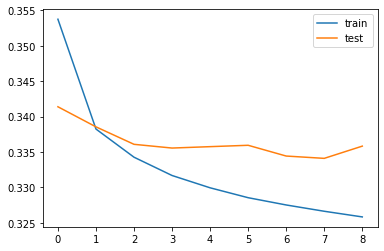

In [216]:
import matplotlib.pyplot as plt
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [220]:
# load a saved model
from keras.models import load_model
saved_model = load_model('models/best_model.h5')

In [235]:
def tweet_pipeline(tweet):
    '''
    Transformation Pipeline of the input tweet.
    STEP:
    - Tokenize the tweet => ['i', 'love', 'you']
    - Convert to LabeledSentence gensim object
    - Build tweet vectorization (word2vec)
    - Scale (zero mean and unit standard deviation)
    
    input:
    raw tweet, string
    output:
    vectorized tweet, np.array (200,)
    '''

    trump_tweet_tokenized = tokenize(tweet)
    
    trump_tweet_labelized = TaggedDocument(trump_tweet_tokenized,'TEST')
    
    tweet_vec = np.concatenate(buildWordVector(trump_tweet_labelized.words, n_dim))
    
    tweet = [scale(tweet_vec)]
    
    return tweet

In [236]:
def sentiment_analysis(tweet, model):
    
    vect_tweet = tweet_pipeline(tweet)
    
    if (vect_tweet[0].ndim == 1):
        vect_tweet[0] = np.array([vect_tweet[0]])
    prediction = model.predict(vect_tweet[0])
    
    return prediction

In [240]:
sentiment_analysis('I love you', saved_model)

C:\Users\theo0\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([[0.71768564]], dtype=float32)

Now that the model is trained, let's evaluate it on the test set:

In [ ]:
score = model.evaluate(test_vecs_w2v, y_test, batch_size=128, verbose=2)
print(score[1])

## Testing

In [ ]:
trump_tweet_labelized.words

In [185]:
#raw tweet
trump_tweet = 'The Radical Left Mayors &  Governors of Cities where this crazy violence is taking place have lost control of their “Movement”. It wasn’t supposed to be like this, but the Anarchists & Agitators got carried away and don’t listen anymore - even forced Slow Joe out of basement!'
#tokenization of the tweet => ['i', 'love', 'you']
trump_tweet_tokenized = tokenize(trump_tweet)
#convert to LabeledSentence objects
trump_tweet_labelized = TaggedDocument(trump_tweet_tokenized,'TEST')
#build world vector
tweet_vec = np.concatenate(buildWordVector(trump_tweet_labelized.words, n_dim))
#scale
tweet2 = [scale(tweet_vec)]

C:\Users\theo0\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [186]:
if (tweet2[0].ndim == 1):
    tweet2[0] = np.array([tweet2[0]])
model.predict(tweet2[0])

array([[0.02822554]], dtype=float32)

## Scrapping Twitter

In [244]:
import GetOldTweets3 as got
def scrapping_twitter(username='realDonaldTrump'):
    count = 2

    tweetCriteria = got.manager.TweetCriteria().setUsername(username)\
                                               .setMaxTweets(count)
    tweet = got.manager.TweetManager.getTweets(tweetCriteria)[0]
    
    return tweet.text

Just watched what Biden had to say. To me, he’s blaming the Police far more than he’s blaming the Rioters, Anarchists, Agitators, and Looters, which he could never blame or he would lose the Radical Left Bernie supports!


In [242]:
sentiment_analysis(tweet.text, saved_model)

C:\Users\theo0\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([[0.13973978]], dtype=float32)